# Deep Genetic Algorithm (DeepGA)

DeepGA es un algoritmo de Neuroevolución de Redes Neuronales Convolucionales (CNN, por sus siglas en Inglés), que busca diseñar arquitecturas de alto desempeño y al mismo tiempo, de poca complejidad.

Este trabajo fue presentado en el Workshop *Neuroevolution@Work* del **Genetic and Evolutionary Computation Conference** (GECCO).

https://dl.acm.org/doi/abs/10.1145/3449726.3463133

**Instalando Librerías**

In [ ]:
!pip install torch torchvision torchaudio torchtext

     |████████████████████████████████| 1.9 MB 4.1 MB/s 


**Importando Librerías**

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
import torchvision
from torchvision import transforms, utils
import cv2
import random
import math
import scipy.io
import urllib.request as req

**Cargando la GPU**

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
print(device)

cuda:0


**Cargando los datos**

Esta aplicación consiste en clasificar imágenes de rayos X de pecho, para identificar COVID-19, pneumonia viral o bacteriana, o un paciente saludable. Se ha recolectado una base de datos de imágenes para realizar la búsqueda de una arquitectura de Red Neuronal Convolucional (CNN) que tenga un alto accuracy, pero con un número de parámetros menor a lo que suele observarse en la literatura especializada

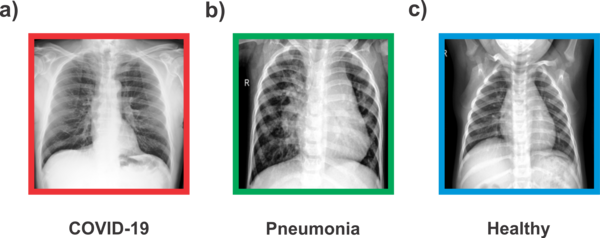

In [ ]:
#Arreglos de etiquetas
num_images = 100
c_labels = np.ones(num_images, dtype = np.int8) #Codiv
n_labels = np.zeros(num_images, dtype = np.int8) #Normal
p_labels = np.full((num_images,), 2) #Pneumonia

#Rutas de las imagenes
c_root = 'https://raw.githubusercontent.com/GustavoVargasHakim/ENC2021-Neuroevolucion/main/Images/COVID-19/covidp'
n_root = 'https://raw.githubusercontent.com/GustavoVargasHakim/ENC2021-Neuroevolucion/main/Images/Normal/normalp'
p_root = 'https://raw.githubusercontent.com/GustavoVargasHakim/ENC2021-Neuroevolucion/main/Images/Pneumonia/pneumoniap'

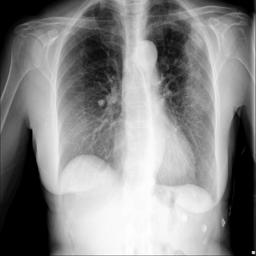

In [ ]:
#Probando el acceso a una imagen
from google.colab.patches import cv2_imshow
new_root = c_root + '1.png'
url = req.urlopen(new_root)
arr = np.asarray(bytearray(url.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
cv2_imshow(img)

In [ ]:
#Clase de Dataset
class CovidDataset(Dataset):
  def __init__(self, root, labels, transform = None):
    self.root = root #La ruta de las imagenes
    self.labels = labels #Arreglo de etiquetas
    self.transform = transform #Composicion de transformaciones
  
  #Medir el número de datos
  def __len__(self):
    return len(self.labels)
  
  #Iterador para llamar a cada ejemplo (X, y)
  def __getitem__(self, idx):
    #idx es el nombre que damos al iterador
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    #Completamos la ruta de cada imagen
    root = self.root[:] 
    img_name = root + str(idx+1) + '.png'

    #Abrimos la imagen desde github
    url = req.urlopen(img_name)
    arr = np.asarray(bytearray(url.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    image = cv2.resize(image, (64,64), interpolation = cv2.INTER_AREA) #Reducir el tamaño de imagenes (opcional)

    #Re-organizamos la estructura de la imagen
    [H, W] = image.shape
    image_p = image.reshape((H,W,1))

    #Obtenemos la etiqueta correspondiente
    label = self.labels[idx]
    sample = {'image': image, 'label': label}

    #Aplicamos alguna transformacion en caso de haberlas
    if self.transform:
      sample = self.transform(sample)

    return sample

#Clase que transforma una imagen tipo numpy en un tensor
class ToTensor(object):
  def __call__(self, sample):
    image, label = torch.from_numpy(sample['image']), sample['label']

    #Cambiar las dimensiones:
    #       imagen numpy:  H x W 
    #       imagen tensor: C x H x W
    image = image.unsqueeze(dim = 0)

    return {'image':image,
            'label':label}

In [ ]:
#Cargando Datasets
covid_ds = CovidDataset(root = c_root, labels = c_labels, transform = transforms.Compose([ToTensor()]))
normal_ds = CovidDataset(root = n_root, labels = n_labels, transform = transforms.Compose([ToTensor()]))
pneumonia_ds = CovidDataset(root = p_root, labels = p_labels, transform = transforms.Compose([ToTensor()]))

In [ ]:
#Uniendo datasets de COVID-19, Pneumonia y normales
dataset = torch.utils.data.ConcatDataset([covid_ds, normal_ds, pneumonia_ds])

#Dividimos datos en entrenamiento y prueba
i = 100
lengths = [int(len(dataset)*0.7), int(len(dataset)*0.3)]
train_ds, test_ds = torch.utils.data.random_split(dataset = dataset, lengths = lengths)

#Probando
print("Tamaño del dataset de entrenamiento: {}".format(len(train_ds)))
print("Tamaño del dataset de prueba: {}".format(len(test_ds)))
print("Forma de las imagenes como tensores: {}".format(dataset[i]['image'].shape))
print("Etiqueta de la imagen i: {}".format(dataset[i]['label']))

Length of Training Dataset: 210
Length of Test Dataset: 90
Shape of images as tensors: torch.Size([1, 64, 64])
Label of image i: 0


In [ ]:
#Creando DataLoaders
train_dl = DataLoader(train_ds, batch_size = 42, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 18, shuffle = True)

"for i_batch, sample_batched in enumerate(test_dl):\n  print(sample_batched['image'].shape)\n  print(sample_batched['label'])\n  break"

**Codificación Híbrida Compacta**

Se trata de una codificación híbrida, pues combina a la cadena de bloques (primer nivel) y a la cadena binaria (segundo nivel). Los bloques que conforman al primer nivel, corresponden a capas convolucionales y y a capas fully-connected. Los bits de la cadena binaria del segundo nivel, representan las conexiones puente entre bloques convolucionales.
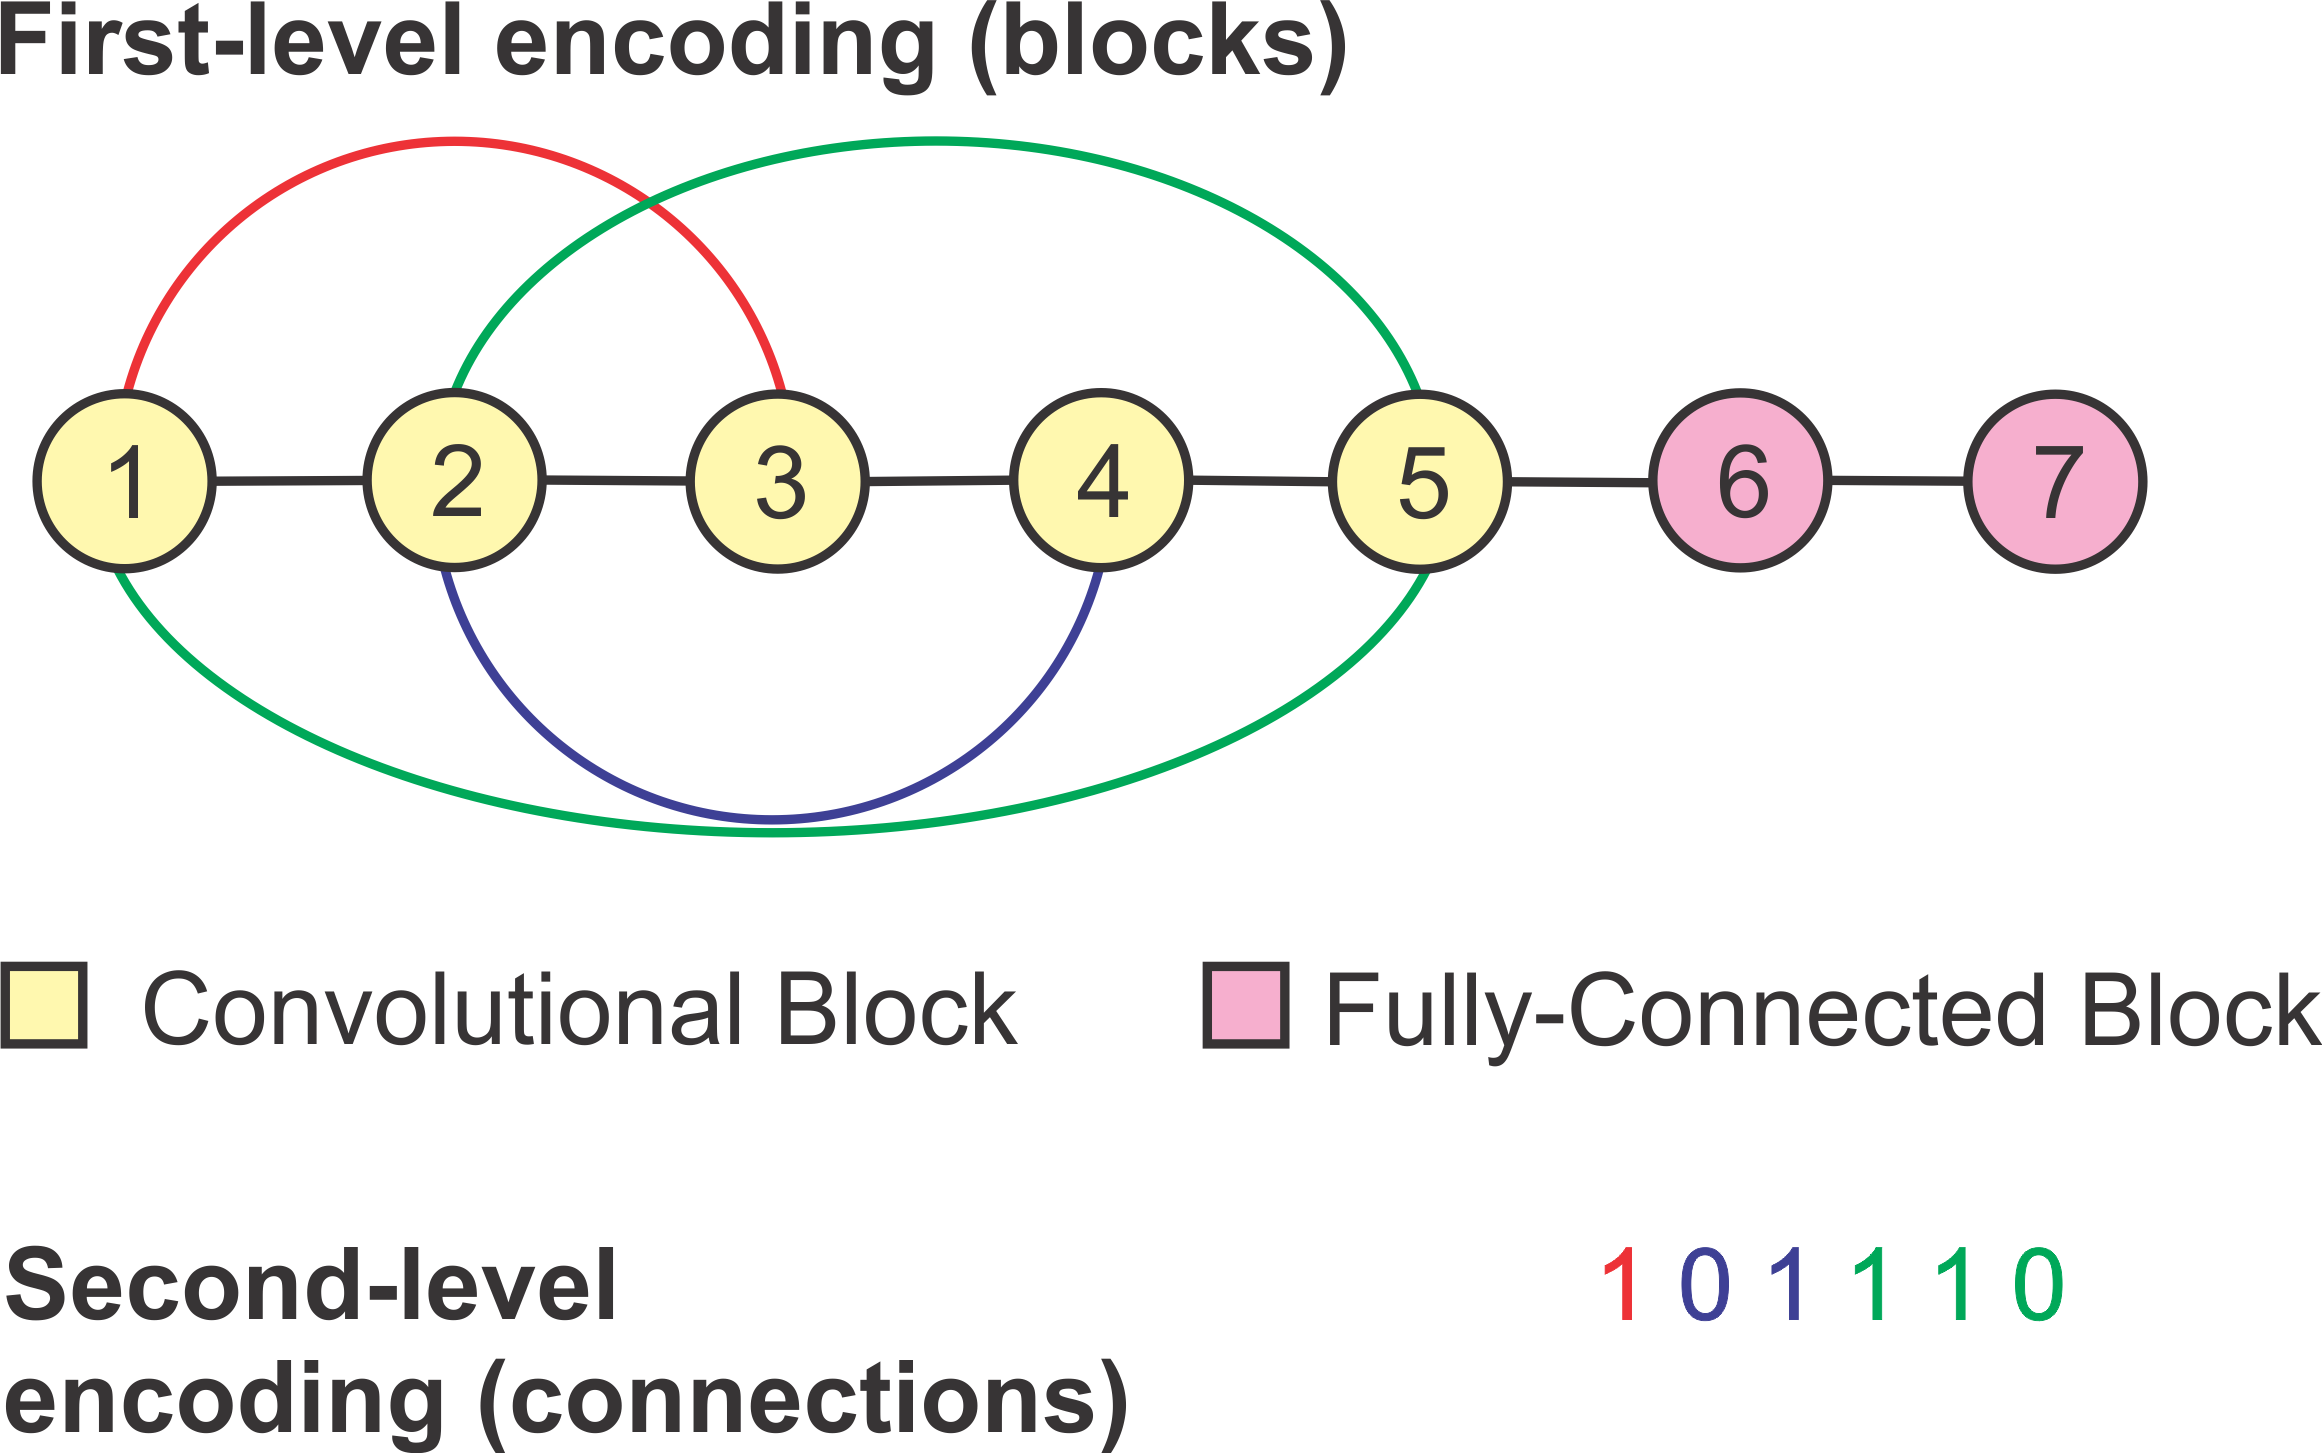

In [ ]:
'''Configuracion de hiperparametros'''
#Capas convolucionales
FSIZES = [1,2,3,4,5,6,7]
NFILTERS = [2,4,8,16,32]

#Capas de Pooling
PSIZES = [2,3,4,5]
PTYPE = ['max', 'avg']

#Capas Fully-connected
NEURONS = [4,8,16,32,64,128]
random.seed(5)

class Encoding:
    def __init__(self, minC, maxC, minF, maxF):
        self.n_conv = random.randint(minC, maxC)
        self.n_full = random.randint(minF, maxF)
        
        
        '''Primer nivel del encoding'''
        self.first_level = []
        
        #Seccion 1: Extraccion de caracteristicas
        for i in range(self.n_conv):
            layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }
            self.first_level.append(layer)
        
        #Seccion 2: Clasificacion
        for i in range(self.n_full):
            layer = {'type' : 'fc',
                     'neurons' : random.choice(NEURONS)}
            
            self.first_level.append(layer)
        
        
        '''Segundo nivel del encoding'''
        self.second_level = []
        prev = -1
        for i in range(self.n_conv):
            if prev < 1:
                prev += 1
            if prev >= 1:
                for _ in range(prev-1):
                    self.second_level.append(random.choice([0,1]))
                prev += 1
        
e = Encoding(2,8,1,4)

In [ ]:
#Calculo de las dimensiones de salida de una capa convolucional
def conv_out_size(W, K):
    return W - K + 3

#Calculo de las dimensiones de salida de una capa de pooling
def pool_out_size(W, K):
    return math.floor((W - K)/2) + 1

In [ ]:
#Decodificacion
def decoding(encoding):
  n_conv = encoding.n_conv
  n_full = encoding.n_full
  first_level = encoding.first_level
  second_level = encoding.second_level

  features = []
  classifier = []
  in_channels = 1
  out_size = 64
  prev = -1
  pos = 0
  o_sizes = []
  for i in range(n_conv):
    layer = first_level[i]
    n_filters = layer['nfilters']
    f_size = layer['fsize']
    pad = 1
    if f_size > out_size:
        f_size = out_size - 1
    if i == 0 or i == 1:
      if layer['pool'] == 'off':
        operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                    nn.BatchNorm2d(n_filters),
                    nn.ReLU(inplace = True)]
        in_channels = n_filters
        out_size = conv_out_size(out_size, f_size)
        o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'avg':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True), 
                      nn.AvgPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'max':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True), 
                      nn.MaxPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])
    else:
      connections = second_level[pos:pos+prev]
      for c in range(len(connections)):
        if connections[c] == 1:
          in_channels += o_sizes[c][1]  

      if layer['pool'] == 'off':
        operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                    nn.BatchNorm2d(n_filters),
                    nn.ReLU(inplace = True)]
        in_channels = n_filters
        out_size = conv_out_size(out_size, f_size)
        o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'avg':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True), 
                      nn.AvgPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      if layer['pool'] == 'max':
          p_size = layer['psize']
          if p_size > out_size:
              p_size = out_size - 1
          operation = [nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = f_size, padding = pad),
                      nn.BatchNorm2d(n_filters),
                      nn.ReLU(inplace = True), 
                      nn.MaxPool2d(kernel_size = p_size, stride = 2)]
          in_channels = n_filters
          out_size = conv_out_size(out_size, f_size)
          out_size = pool_out_size(out_size, p_size)
          o_sizes.append([out_size, in_channels])

      pos += prev
    prev += 1
      
    features.append(operation)
  in_size = out_size*out_size*in_channels
  for i in range(n_conv,(n_conv + n_full)):
    layer = first_level[i]
    n_neurons = layer['neurons']
    classifier += [nn.Linear(in_size, n_neurons)]
    classifier += [nn.ReLU(inplace = True)]
    in_size = n_neurons

  #En la ultima capa, agregamos tres neuronas para la capa de softmax (clasificacion de 3 clases)
  classifier += [nn.Linear(n_neurons, 3)]

  return features, classifier, o_sizes

In [ ]:
'''Networks class'''
class CNN(nn.Module):
  def __init__(self, encoding, features, classifier, sizes, init_weights = True):
    super(CNN, self).__init__()
    extraction = []
    for layer in features:
      extraction += layer
    self.extraction = nn.Sequential(*extraction)
    self.classifier = nn.Sequential(*classifier)
    self.features = features
    self.second_level = encoding.second_level
    self.sizes = sizes
    
  def forward(self, x):
    '''Feature extraction'''
    prev = -1
    pos = 0
    outputs = {}
    features = self.features
    #print(x.shape)
    for i in range(len(features)):
      #print('Layer: ', i)
      if i == 0 or i == 1:
        x = nn.Sequential(*features[i])(x)
        outputs[i] = x
        #print(x.shape)
      
      else:
        connections = self.second_level[pos:pos+prev]
        for c in range(len(connections)):
          if connections[c] == 1:
            skip_size = self.sizes[c][0] #Tamaño proveniente de la capa anterior
            req_size = x.shape[2] #Tamaño del mapa de activacion actual
            #print('X: ',x.shape)
            if skip_size > req_size:
              psize = skip_size - req_size + 1 
              pool = nn.MaxPool2d(kernel_size = psize, stride = 1) #Aplicar pooling para hacer compatibles a los mapas de activacion
              x2 = pool(outputs[c])
            if skip_size == req_size:
              x2 = outputs[c]
            if req_size == skip_size + 1:
              pool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = (1,1))
              x2 = pool(outputs[c])
            if req_size == skip_size + 2:
              pad = int((req_size - skip_size)/2)
              padding = nn.ZeroPad2d(pad)
              x2 = padding(outputs[c])
            #print('X2: ',x2.shape)
            x = torch.cat((x, x2), axis = 1)
          
        x = nn.Sequential(*features[i])(x)
        #print('Out size: ', x.shape)
        outputs[i] = x
        pos += prev
      
      prev += 1
    

    x = torch.flatten(x,1)
    x = self.classifier(x)

    return nn.functional.log_softmax(x, dim=1)

**Operadores Genéticos**

Los operadores genéticos incluyen a la **cruza** y a la **mutación**. 

La **cruza** se aplica en los dos niveles de la codificación. En el primer nivel, se intercambia la mitad de los bloques del padre de menor tamaño, por el número de bloques equivalente del otro padre.

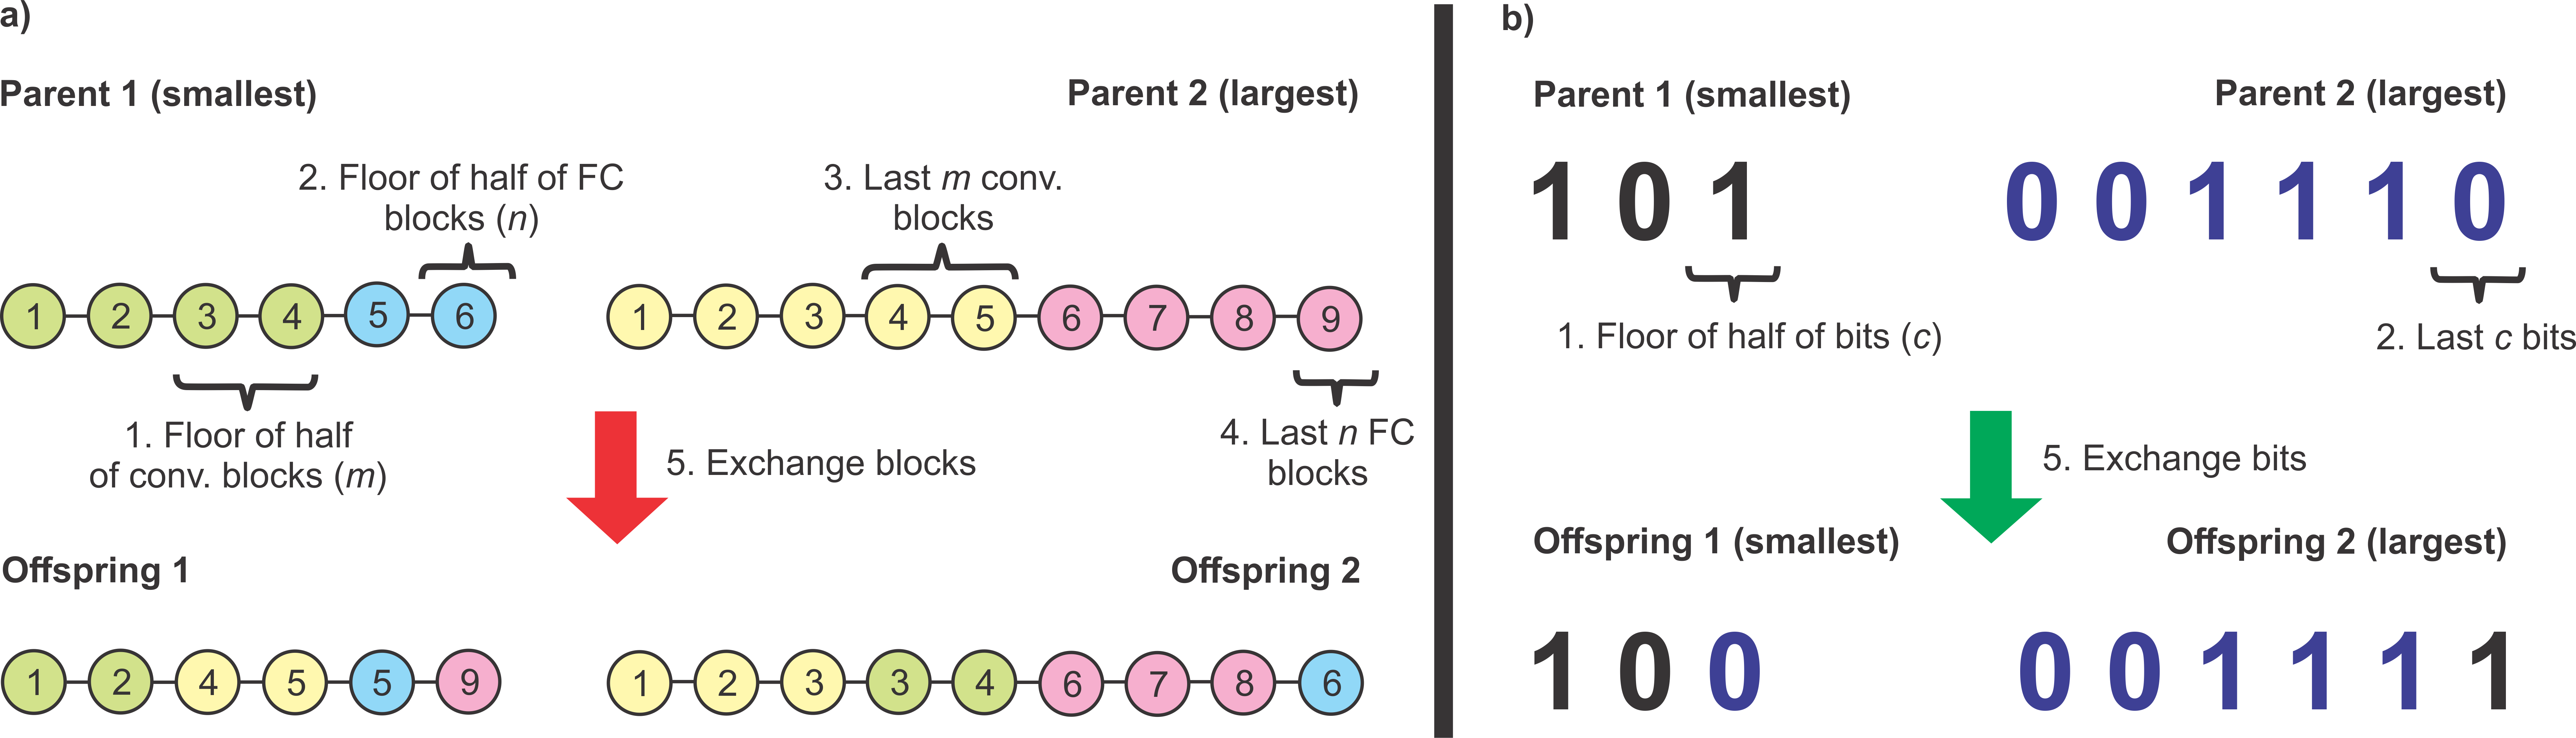

La **mutación** se aplica también en los dos niveles. En el primer nivel, hay dos posibles mutaciones al azar: (a) seleccionar un bloque al azar y reiniciar sus hiperparámetros, o (b) insertar un nuevo bloque en una posición al azar. NOTA: si el nuevo bloque es un bloque convolucional, es necesario hacer un ajuste en la cadena binaria para compensar las conexiones puente que existían y para añadir las nuevas que sean correspondientes.

En el segundo nivel, la mutación consiste simplemente en seleccionar un bit al azar de la cadena binaria, y cambiar su valor.

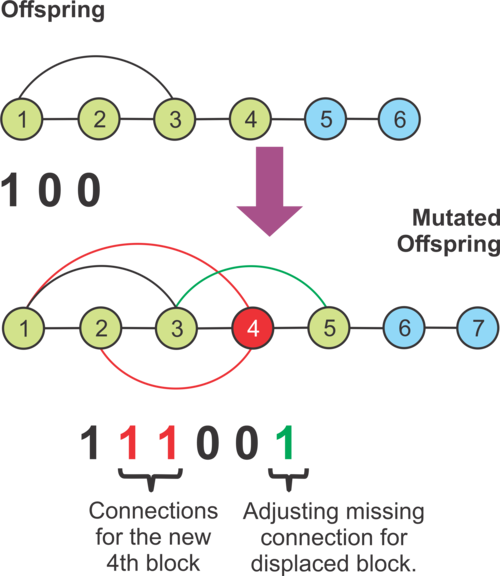

In [ ]:
from copy import deepcopy

#Funcion de cruza
def crossover(x, y):
    x = deepcopy(x)
    y = deepcopy(y)
    
    '''Primer padre'''
    x_nconv = x.n_conv
    x_nfull = x.n_full
    xblocks = x.first_level
    xbinary = x.second_level
    
    '''Segundo padre'''
    y_nconv = y.n_conv
    y_nfull = y.n_full
    yblocks = y.first_level
    ybinary = y.second_level
    
    '''Cruza de la seccion convolucional'''
    if x_nconv > y_nconv:
        k = math.floor(y_nconv/2)
        index = list(range(x_nconv))
        
        '''Intercambiando los k ultimos bloques del padre de menor tamaño'''
        for i in range(k, y_nconv):
            block = yblocks[i] #i-esimo bloque
            ix = random.choice(index) #Seleccionamos indice aleatorio del padre de mayor tamaño
            index.remove(ix)
            
            #Intercambio de bloques
            yblocks[i] = xblocks[ix]
            xblocks[ix] = block
    
    if y_nconv > x_nconv:
        k = math.floor(x_nconv/2)
        index = list(range(y_nconv))
        
        '''Intercambiando los k ultimos bloques del padre de menor tamaño'''
        for i in range(k, x_nconv):
            block = xblocks[i] #i-esimo bloque
            ix = random.choice(index) #Seleccionamos indice aleatorio del padre de mayor tamaño
            index.remove(ix)
            
            #Intercambio de bloques
            xblocks[i] = yblocks[ix]
            yblocks[ix] = block
    
    if x_nconv == y_nconv:
        k = math.floor(x_nconv/2)
        index = list(range(x_nconv))
        
        x_part = xblocks[k:x_nconv]
        
        '''Intercambiando la segunda mitad de los bloques'''
        xblocks[k:x_nconv] = yblocks[k:y_nconv]
        yblocks[k:y_nconv] = x_part
            
    '''Cruza de la seccion de clasificacion'''
    if x_nfull > y_nfull:
        k = math.floor(y_nfull/2)
        index = list(range(x_nconv, x_nconv + x_nfull))
        
        '''Intercambiando los k ultimos bloques del padre de menor tamaño'''
        for i in range(y_nconv + k, y_nconv + y_nfull):
            block = yblocks[i] #i-esimo bloque
            ix = random.choice(index) #Seleccionamos indice aleatorio del padre de mayor tamaño
            index.remove(ix)
            
            #Intercambio de bloques
            yblocks[i] = xblocks[ix]
            xblocks[ix] = block
    
    if y_nfull > x_nfull:
        k = math.floor(x_nfull/2)
        index = list(range(y_nconv, y_nconv + y_nfull))
        
        '''Intercambiando los k ultimos bloques del padre de menor tamaño'''
        for i in range(x_nconv + k, x_nconv + x_nfull):
            block = xblocks[i] #i-esimo bloque
            ix = random.choice(index) #Seleccionamos indice aleatorio del padre de mayor tamaño
            index.remove(ix)
            
            #Intercambio de bloques
            xblocks[i] = yblocks[ix]
            yblocks[ix] = block
    
    if x_nfull == y_nfull:
        k = math.floor(x_nfull/2)
        
        x_part = xblocks[x_nconv + k:x_nconv + x_nfull]
        '''Intercambiando la segunda mitad de los bloques'''
        xblocks[x_nconv + k:x_nconv + x_nfull] = yblocks[y_nconv + k:y_nconv + y_nfull]
        yblocks[y_nconv + k:y_nconv + y_nfull] = x_part       
    
    '''Segundo nivel'''
    if len(xbinary) > len(ybinary):
        if len(ybinary) > 1 :
            k = random.choice(list(range(1, len(ybinary))))
            partition = ybinary[k:]
            nbits = len(partition)
        
            if random.uniform(0,1) >= 0.5:
                ybinary[k:] = xbinary[len(xbinary) - nbits:len(xbinary)]
                xbinary[len(xbinary) - nbits:len(xbinary)] = partition
            else:
                ybinary[k:] = xbinary[:nbits]
                xbinary[:nbits] = partition
    
    if len(ybinary) > len(xbinary):
        if len(xbinary) > 1 :
            k = random.choice(list(range(len(xbinary))))
            partition = xbinary[k:]
            nbits = len(partition)
            
            if random.uniform(0,1) >= 0.5:
                xbinary[k:] = ybinary[len(ybinary) - nbits:len(ybinary)]
                ybinary[len(ybinary) - nbits:len(ybinary)] = partition
            else:
                xbinary[k:] = ybinary[:nbits]
                ybinary[:nbits] = partition
        
    if len(xbinary) == len(ybinary):
        if len(xbinary) > 1 :
            k = random.choice(list(range(len(xbinary))))
            partition = xbinary[k:]
        
            xbinary[k:] = ybinary[k:]
            ybinary[k:] = partition
    
    return x, y  

#Funcion de mutacion
def mutation(x):
    if random.uniform(0,1) < 0.5:
        '''Adding a new block'''
        if random.uniform(0,1) > 0.5:
            #Agregando un bloque fully-connected
            layer = {'type' : 'fc',
                     'neurons' : random.choice(NEURONS)}
            
            #Eligiendo una posicion al azar para insertar el nuevo bloque
            index = list(range(x.n_conv, x.n_conv + x.n_full))
            ix = random.choice(index)
            
            x.first_level.insert(ix, layer)
            x.n_full += 1
        
        else:
            #Agregando un bloque convolucional
            layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }
            #Eligiendo una posicion al azar para insertar el nuevo bloque
            index = list(range(x.n_conv))
            ix = random.choice(index)
            
            x.first_level.insert(ix, layer)
            x.n_conv += 1
            
            #La cadena binaria debe ajustarse
            if ix > 1:
                new_bits = []
                for i in range(ix - 1):
                    new_bits.append(random.choice([0,1]))
                pos = int(0.5*(ix**2) - 1.5*(ix) + 1)
                start = pos + len(new_bits)
                for bit in new_bits:
                    x.second_level.insert(pos, bit)
                    pos += 1
                
                rest = x.n_conv - ix - 1
                add = ix
                for j in range(rest):
                    x.second_level.insert(start+add-1, random.choice([0,1]))
                    start += add
                    ix += 1
            
            if ix == 0 or ix == 1:
                if x.n_conv - 1 == 2:
                    x.second_level.append(random.choice([0,1]))
                else:
                    add = 0
                    for i in range(2, x.n_conv):
                        pos = int(0.5*(ix**2) - 1.5*(ix) + 1) + add
                        x.second_level.insert(pos, random.choice([0,1]))
                        add += 1
                
    else:
        '''Cambiando hiperparametros en un bloque al azar'''
        if random.uniform(0,1) > 0.5:
            '''Reiniciando bloque fully-connected'''
            index = list(range(x.n_conv, x.n_conv + x.n_full))
            ix = random.choice(index)
            new_layer = {'type' : 'fc',
                         'neurons' : random.choice(NEURONS)}
            #Sustituimos los hiperparametros anteriores con los nuevos
            x.first_level[ix] = new_layer
            
        else:
            '''Reiniciando un bloque convolucional'''
            index = list(range(x.n_conv))
            ix = random.choice(index)
            new_layer = {'type' : 'conv',
                     'nfilters' : random.choice(NFILTERS),
                     'fsize' : random.choice(FSIZES),
                     'pool' : random.choice(['max', 'avg', 'off']),
                     'psize' : random.choice(PSIZES)
                    }
            
            #Sustituimos los hiperparametros anteriores con los nuevos
            x.first_level[ix] = new_layer
        
        '''Modificando conexiones en el segundo nivel de la codificacion'''
        if len(x.second_level) > 0:
            k = random.choice(list(range(len(x.second_level))))
            #Un bit en el segundo nivel se cambia de 0 a 1 o de 1 a 0
            if x.second_level[k] == 1:
                x.second_level[k] = 0
            else:
                x.second_level[k] = 1
    
#Funcion de seleccion de padres
def selection(tournament, style):
    '''Torneo estocastico modificado'''
    if style == 'max':
        if random.uniform(0,1) <= 0.8:
            p = max(tournament, key = lambda x: x[1])
        else:
            p = random.choice(tournament)
    else:
        if random.uniform(0,1) <= 0.8:
            p = min(tournament, key = lambda x: x[1])
        else:
            p = random.choice(tournament)
    
    return p

**Entrenamiento**

El entrenamiento de cada individuo consiste en el algoritmo de retropropagación para optimizar los pesos de las CNNs.

In [ ]:
#Funcion auxiliar: computar la funcion de perdida de un batch
def loss_batch(loss_func, xb, yb, yb_h, opt = None):
  #Obtener la funcion de perdida del batch
  loss = loss_func(yb_h, yb)
  #Calcular accuracy del batch
  metric_b = metrics_batch(yb, yb_h)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none = True)
  
  return loss.item(), metric_b

#Funcion auxiliar: calcular el accuracy de un batch
def metrics_batch(target, output):
  #Obtener las predicciones de clase
  pred = output.argmax(dim=1, keepdim = True)
  #Comparar las predicciones con las clases reales
  corrects = pred.eq(target.view_as(pred)).sum().item()

  #Devolver el numero de predicciones correctas
  return corrects

#Funcion aucciliar: calcular la funcion de perdida y el accuracy para un epoca
def loss_epoch(device, model, loss_func, dataset_dl, opt = None):
  loss = 0.0
  metric = 0.0
  len_data = len(dataset_dl.dataset)
  for i, data in enumerate(dataset_dl, 0):
    xb, yb = data['image'], data['label']
    xb = xb.type(torch.double).to(device, dtype = torch.float32)
    yb = yb.to(device, dtype = torch.long)
    
    #Obtener salida de la CNN
    yb_h = model(xb)

    loss_b, metric_b = loss_batch(loss_func, xb, yb, yb_h, opt)
    loss += loss_b
    if metric_b is not None:
      metric += metric_b
  
  loss /= len_data
  metric /= len_data

  return loss, metric

La función objetivo ($f$) de DeepGA se compone de dos elementos: (a) el **accuracy** de las CNN y (b) una relación entre el **número de parámetros** de la CNN ($NP$) y un **valor máximo permitido de parámetros** ($MP$) definido por el usuario. Ambas componentes se suman como una *función agregativa lineal* a través del **peso de complejidad** $w$:




$f(cnn) = (1-w)accuracy(cnn)+w\frac{MP - NP}{MP}$

In [ ]:
def train_val(device, epochs, model, loss_func, train_dl, test_dl, max_params):
  lr = 1e-4
  opt = torch.optim.Adam(model.parameters(), lr = lr)

  #Medir numero de parametros
  params = sum(p.numel() for p in model.parameters() if p.requires_grad)

  #Mover la CNN a la GPU
  model.to(device)

  #Entrenamiento de la CNN
  model.train()
  for epoch in range(epochs):
    train_loss, train_metric = loss_epoch(device, model, loss_func, train_dl, opt)
  
  #Evaluacion de la CNN
  model.eval()
  with torch.no_grad():
    val_loss, val_metric = loss_epoch(device, model, loss_func, test_dl)
  accuracy = val_metric

  #Calculo de la funcion objetivo agregativa lineal
  f = (1 - w)*accuracy + w*((max_params - params)/max_params)

  return f, accuracy, params

**DeepGA**

A continuación se muestran los diferentes parámetros a los que el usuario tiene acceso, y que se relacionan con el desempeño de DeepGA, tanto en la calidad de las soluciones finales, como en el tiempo de ejecución. Con la configuración actual, se estima que el tiempo de ejecución con 20 generaciones, no supere las 12 horas continuas.

In [ ]:
#Maximo y minimo numero de bloques para inicializar a los individuos
min_conv = 2
max_conv = 4
min_full = 1
max_full = 4

'''Parametros del algoritmo genetico'''
cr = 0.7 #Probabilidad de cruza
mr = 0.3 #Probabilidad de mutacion
N = 18 #Tamaño de la poblacion
t_size = 3 #Tamaño de torneo
w = 0.3 #Peso de complejidad
max_params = 2e6
lr = 1e-4
num_epochs = 8
loss_func = nn.NLLLoss(reduction = "sum")

In [ ]:
'''Inicializacion de la poblacion'''
bestAcc = [] #Lista para contener al mejor accuracy de cada generacion
bestF = [] #Lista para contener a la mejor funcion objetivo de cada generacion
bestParams =[] #Lista para contener al mejor numero de parametros de cada generacion
pop = [] #Lista de la poblacion
while len(pop) < N:
  print(len(pop))
  #Generando codificacion
  e = Encoding(min_conv, max_conv, min_full, max_full)

  #Decodificando
  network = decoding(e)

  #Creando la CNN
  cnn = CNN(e, network[0], network[1], network[2])

  #Evaluacion del individuo
  f, acc, params = train_val(device, epochs = num_epochs, model = cnn, 
                             loss_func = loss_func, train_dl = train_dl, 
                             test_dl = test_dl, max_params = max_params)
  
  #Introducing valores a la poblacion
  pop.append([e, f, acc, params])

  

#Extraer el mejor individuo respecto a las metricas
bestF.append(max(pop, key = lambda x: x[1])[1])
bestAcc.append(max(pop, key = lambda x: x[2])[2])
bestParams.append(min(pop, key = lambda x: x[3])[3])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
T = 20 #Numero de generaciones

In [ ]:
'''Algoritmo genetico'''
for t in range(T):
    print('Generation: ', t)
    
    #Seleccion de padres
    parents = []
    while len(parents) < int(N/2):
        #Seleccion por torneo
        tournament = random.sample(pop, t_size)
        p1 = selection(tournament, 'max')
        tournament = random.sample(pop, t_size)
        p2 = selection(tournament, 'max')
        while p1 == p2:
            tournament = random.sample(pop, t_size)
            p2 = selection(tournament, 'max')  
        
        parents.append(p1)
        parents.append(p2)

    offspring = []
    while len(offspring) < int(N/2):
        par = random.sample(parents, 2)
        #Cruza + mutacion
        if cr >= random.uniform(0,1): #Cruza
            p1 = par[0][0]
            p2 = par[1][0]
            c1, c2 = crossover(p1, p2)
            
            #Mutacion
            if mr >= random.uniform(0,1):
                mutation(c1)
            
            if mr >= random.uniform(0,1):
                mutation(c2)
            
            network = decoding(c1)
            cnn = CNN(c1, network[0], network[1], network[2])
            f, acc, params = train_val(device, epochs = num_epochs, model = cnn, 
                             loss_func = loss_func, train_dl = train_dl, 
                             test_dl = test_dl, max_params = max_params)
            offspring.append([c1, f, acc, params])

            torch.cuda.empty_cache()
            
            network = decoding(c2)
            cnn = CNN(c2, network[0], network[1], network[2])
            f, acc, params = train_val(device, epochs = num_epochs, model = cnn, 
                             loss_func = loss_func, train_dl = train_dl, 
                             test_dl = test_dl, max_params = max_params)
            offspring.append([c2, f, acc, params])
            
    #Reemplazo con miu + lambda
    pop = pop + offspring
    pop.sort(reverse = True, key = lambda x: x[1])
    pop = pop[:N]

    #Ordenando a la poblacion en funcion de la aptitud
    leader = max(pop, key = lambda x: x[1])
    
    print('Mejor aptitud: ', leader[1])
    print('Mejor Accuracy: ', leader[2])
    print('Mejor No. de parametros: ', leader[3])
    print('No. de capas convolucionales: ', leader[0].n_conv)
    print('No. de capas fully-connected: ', leader[0].n_full)
    print('--------------------------------------------')

    #Actualizando mejores valores para graficacion
    bestF.append(leader[1])
    bestAcc.append(leader[2])
    bestParams.append(leader[3])

Generation:  0
Mejor aptitud:  0.9434424833333332
Mejor Accuracy:  0.9333333333333333
Mejor No. de parametros:  65939
No. de capas convolucionales:  3
No. de capas fully-connected:  1
--------------------------------------------
Generation:  1
Mejor aptitud:  0.9458562166666666
Mejor Accuracy:  0.9666666666666667
Mejor No. de parametros:  205403
No. de capas convolucionales:  4
No. de capas fully-connected:  1
--------------------------------------------
Generation:  2
Mejor aptitud:  0.9458562166666666
Mejor Accuracy:  0.9666666666666667
Mejor No. de parametros:  205403
No. de capas convolucionales:  4
No. de capas fully-connected:  1
--------------------------------------------
Generation:  3
Mejor aptitud:  0.9565926166666666
Mejor Accuracy:  0.9666666666666667
Mejor No. de parametros:  133827
No. de capas convolucionales:  3
No. de capas fully-connected:  1
--------------------------------------------
Generation:  4
Mejor aptitud:  0.9565926166666666
Mejor Accuracy:  0.966666666666

**Graficación**

In [ ]:
font_title = {'family' : 'serif',
              'color' : 'darkred',
              'weight' : 'normal',
              'size' : '16'}

font_labels = {'family' : 'serif', 
               'color' : 'black',
               'weight' : 'bold', 
               'size' : 12}

Text(0.5, 1.0, 'Gráfica de convergencia 1: Función de Aptitud')

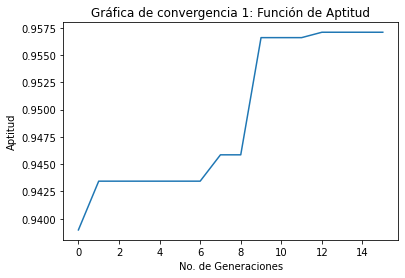

In [ ]:
import matplotlib.pyplot as plt
iter = [i for i in range(len(bestF))]
plt.plot(iter, bestF)
plt.xlabel('No. de Generaciones', font_dict = font_labels)
plt.ylabel('Aptitud', font_dict = font_labels)
plt.title('Gráfica de convergencia 1: Función de Aptitud', fontdict = font_title)

Text(0.5, 1.0, 'Gráfica de convergencia 2: Accuracy')

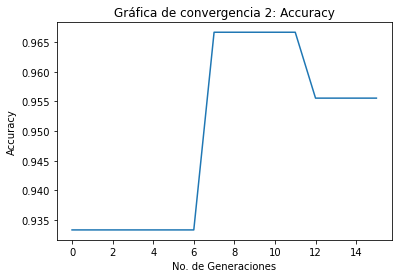

In [ ]:
plt.plot(iter, bestAcc)
plt.xlabel('No. de Generaciones', font_dict = font_labels)
plt.ylabel('Accuracy', font_dict = font_labels)
plt.title('Gráfica de convergencia 2: Accuracy', fontdict = font_title)

Text(0.5, 1.0, 'Gráfica de convergencia 3: No. de Parametros')

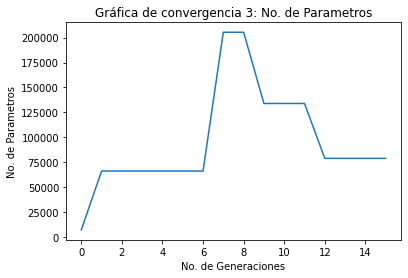

In [ ]:
plt.plot(iter, bestParams)
plt.xlabel('No. de Generaciones', font_dict = font_labels)
plt.ylabel('No. de Parametros', font_dict = font_labels)
plt.title('Gráfica de convergencia 3: No. de Parametros', fontdict = font_title)